In [1]:
%matplotlib inline


# Comet
import comet_ml
from comet_ml import Experiment 

# Standard packages
import os
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nltk for preprocessing of text data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# Keras for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Random seeds for consistent results
from tensorflow import set_random_seed
seed = 1234
np.random.seed(seed)
set_random_seed(seed)

Using TensorFlow backend.


In [2]:
DATA = '/Users/nikolaskaris/Desktop/twitter-airline-sentiment/'

In [3]:
print('\n# Files and file sizes')
for file in os.listdir(DATA):
    print('{} | {} MB'.format(file.ljust(30), str(round(os.path.getsize(DATA + file) / 1000000, 2))))


# Files and file sizes
database.sqlite                | 5.04 MB
Tweets.csv                     | 3.42 MB


In [4]:
raw_df = pd.read_csv(f'{DATA}Tweets.csv')
print('Raw Dataframe:')
raw_df.head(1)

Raw Dataframe:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)


In [5]:
# Select features
df = raw_df[['tweet_id', 'text', 'airline_sentiment']]
print('Feature selected DataFrame:')
df.head(2)

Feature selected DataFrame:


,tweet_id,text,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive


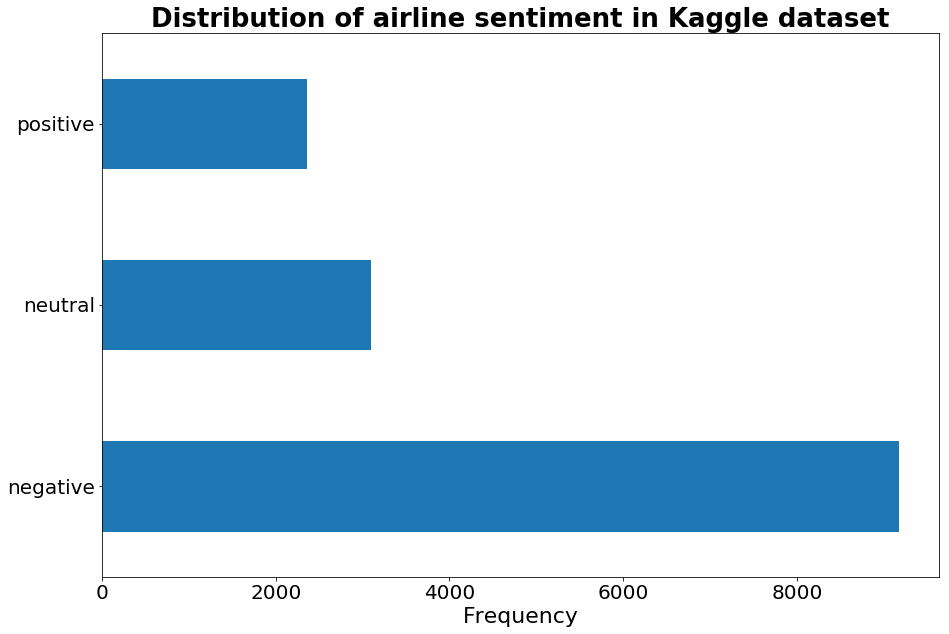

In [6]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Distribution of airline sentiment in Kaggle dataset', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

In [7]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe and column name for the tweets
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get truncated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.preprocessed

In [8]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()

/Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Shuffling so we can get random tweets for the test set
df = shuffle(df, random_state=seed)
# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [10]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment labels for test set
y_test = test_set['airline_sentiment']


In [11]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])


In [12]:
# Print the size of our data
print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')


Training size: 10912 tweets
Validation size: 2728 tweets
Test size: 1000 tweets
Amount of words (columns): 9672 words


## Initialize Comet Experiment

In [13]:
experiment = Experiment(api_key="kZ9EvZnOe5Kdw40yNNY4UXNu3",
                        project_name="singapore airlines", workspace="demos")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/demos/singapore-airlines/b519e9e56116462d9c1c5927ffba4686



## LGBM

In [22]:
# # sklearn's Gradient Boosting Classifier (GBM)
# gbm = GradientBoostingClassifier(n_estimators=200, 
#                                  max_depth=6, 
#                                  random_state=seed)
# gbm.fit(X_train, y_train)
# # Check results
# train_pred = gbm.predict(X_train)
# val_pred = gbm.predict(X_val)
# print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
# print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

## XGBOOST

In [28]:
# # Hyperparameters that you can tweak
# # There are a lot more tweakable hyperparameters that you can find at 
# # https://xgboost.readthedocs.io/en/latest/parameter.html
# xgb_params = {'objective' : 'multi:softmax',
#               'eval_metric' : 'mlogloss',
#               'eta' : 0.1,
#               'max_depth' : 6,
#               'num_class' : 3,
#               'lambda' : 0.8,
#               'estimators' : 200,
#               'seed' : seed
              
# }

# # Transform categories into numbers
# # negative = 0, neutral = 1 and positive = 2
# target_train = y_train.astype('category').cat.codes
# target_val = y_val.astype('category').cat.codes

# # Transform data into a matrix so that we can use XGBoost
# d_train = xgb.DMatrix(X_train, label = target_train)
# d_val = xgb.DMatrix(X_val, label = target_val)

# # Fit XGBoost
# watchlist = [(d_train, 'train'), (d_val, 'validation')]
# bst = xgb.train(xgb_params, 
#                 d_train, 
#                 400,  
#                 watchlist,
#                 early_stopping_rounds = 50, 
#                 verbose_eval = 0)

# # Check results for XGBoost
# train_pred = bst.predict(d_train)
# val_pred = bst.predict(d_val)
# print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
# print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

## Neural Net

In [14]:
# Generator so we can easily feed batches of data to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [15]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]

# Initialize sklearn's one-hot encoder class
onehot_encoder = OneHotEncoder(sparse=False)

# One hot encoding for training set
integer_encoded_train = np.array(y_train).reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

# One hot encoding for validation set
integer_encoded_val = np.array(y_val).reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

In [16]:
# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

# Build model architecture
model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 20
batch_size = 32

# Fit the model using the batch_generator
hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])

W0730 22:01:34.594183 4594013632 deprecation_wrapper.py:119] From /Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 22:01:34.612426 4594013632 deprecation_wrapper.py:119] From /Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 22:01:34.618006 4594013632 deprecation_wrapper.py:119] From /Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0730 22:01:34.660066 4594013632 deprecation_wrapper.py:119] From /Users/nikolaskaris/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.

Epoch 1/20
341/341 [==============================] - 3s 10ms/step - loss: 0.5784 - acc: 0.6980 - val_loss: 0.5197 - val_acc: 0.8069
Epoch 2/20
341/341 [==============================] - 4s 13ms/step - loss: 0.5007 - acc: 0.7785 - val_loss: 0.4724 - val_acc: 0.7826
Epoch 3/20
341/341 [==============================] - 3s 9ms/step - loss: 0.4636 - acc: 0.7897 - val_loss: 0.4431 - val_acc: 0.7996
Epoch 4/20
341/341 [==============================] - 4s 12ms/step - loss: 0.4307 - acc: 0.8090 - val_loss: 0.4175 - val_acc: 0.8115
Epoch 5/20
341/341 [==============================] - 5s 14ms/step - loss: 0.4003 - acc: 0.8229 - val_loss: 0.3962 - val_acc: 0.8239
Epoch 6/20
341/341 [==============================] - 7s 20ms/step - loss: 0.3748 - acc: 0.8346 - val_loss: 0.3787 - val_acc: 0.8319
Epoch 7/20
341/341 [==============================] - 8s 23ms/step - loss: 0.3528 - acc: 0.8475 - val_loss: 0.3647 - val_acc: 0.8385
Epoch 8/20
341/341 [==============================] - 4s 13ms/step - l

In [17]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/demos/singapore-airlines/b519e9e56116462d9c1c5927ffba4686
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [39]           : (0.697977785840412, 0.928152504554592)
COMET INFO:     batch_acc [1399]   : (0.65625, 0.9895833730697632)
COMET INFO:     batch_loss [1399]  : (0.10071663558483124, 0.6387514472007751)
COMET INFO:     epoch_duration [39]: (2.9202728159999936, 7.962073739999994)
COMET INFO:     loss [39]          : (0.2070881759971817, 0.5784315054367715)
COMET INFO:     step               : 6820
COMET INFO:     val_acc [39]       : (0.7826246488129288, 0.8649804562417642)
COMET INFO:     val_loss [39]      : (0.3152835238014848, 0.5197180348757076)
COMET INFO:   Other [count]:
COMET INFO:     trainable_params: 193523
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (may t